# Итоговый проект по курсу "Введение в открытые данные"

Выполнила: *Авлеева Ульяна Андреевна*

**Цель работы**: воспользуемся неофициальным API Кинопоиска `api.kinopoisk.dev`, чтобы собрать информацию о русских фильмах. Попробуем собрать статистику по самым успешным режиссерам в своих жанрах. С помощью этой информации продюссер сможет на основе открытых данных принять решение о том, какой режиссер снимает в данном жанре наиболее успешную и высокооцененную картину.

## 1. Сбор данных о русских фильмах через API Кинопоиска

Документация: https://kinopoiskdev.readme.io/reference/%D1%84%D0%B8%D0%BB%D1%8C%D0%BC%D1%8B-%D1%81%D0%B5%D1%80%D0%B8%D0%B0%D0%BB%D1%8B-%D0%B8-%D1%82%D0%B4

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')


key = "см тг"

Собираем информацию таким образом:


1.   ***Страна:*** Россия
2.   ***Тип контента:*** Фильмы
3.   ***Жанры:*** Исключаем короткометражки
4.   ***Рейтинг:*** Исключаем фильмы, у которых рейтинг Кинопоиска равен нулю
5.   ***Ограничения целостности:*** NotNull для Названия фильма, Года выпуска, Жанров, Персон (из них достанем режиссеров)

Цель данного этапа заключается в том, чтобы настроить запрос на максимальную точность и корректность для исследуемой задачи. Парсинг Кинопоиска через API платный, поэтому неразумно парсить весь сайт целиком и заниматься фильтрацией после, необходимо в самом начале постараться по максимуму избавиться от "мусора".


Для сбора используем эндпоинт /movie с дополнительными параметрами. В ответе придут поля указанные в параметре selectFields, можно установить ограничения целостности с помощью параметра notNullFields и явные фильтры по значениям параметров.

Подробнее: https://kinopoiskdev.readme.io/reference/moviecontroller_findmanybyqueryv1_4

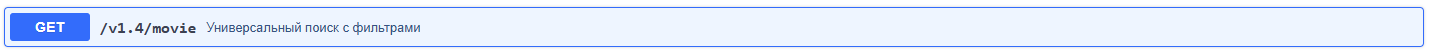

In [17]:
import requests
import time


countries = ['Россия']
page_id = 10

request = f'https://api.kinopoisk.dev/v1.4/movie?page={page_id}&limit=100&selectFields=id&selectFields=externalId&selectFields=name&selectFields=alternativeName&selectFields=enName&selectFields=type&selectFields=year&selectFields=movieLength&selectFields=isSeries&selectFields=ratingMpaa&selectFields=ageRating&selectFields=typeNumber&selectFields=status&selectFields=names&selectFields=rating&selectFields=votes&selectFields=genres&selectFields=countries&selectFields=releaseYears&selectFields=persons&selectFields=budget&notNullFields=name&notNullFields=genres.name&notNullFields=year&notNullFields=rating.kp&notNullFields=persons.profession&countries.name={countries[0]}&persons.enProfession=director&rating.kp=0.1-10&typeNumber=1&genres.name=!короткометражка'


In [18]:
page = requests.get(request, headers ={'accept': 'application/json', 'X-API-KEY': key})
page


<Response [200]>

In [19]:
res = page.json()
import pandas as pd
films_df = pd.DataFrame(res['docs'])
films_df

,id,externalId,name,alternativeName,enName,names,type,typeNumber,year,status,rating,votes,movieLength,ratingMpaa,ageRating,genres,countries,persons,budget,isSeries
0,924347,"{'kpHD': '469b02f28e07a0a49dc3a81ad1fbc0b1', '...",Грецкий орешек,None,None,"[{'name': 'Gretskiy Oreshek', 'language': 'RU'...",movie,1,2018,None,"{'kp': 6.313, 'imdb': 0, 'filmCritics': 0, 'ru...","{'kp': 33123, 'imdb': 0, 'filmCritics': 0, 'ru...",83,None,18,"[{'name': 'комедия'}, {'name': 'приключения'}]",[{'name': 'Россия'}],"[{'id': 1831120, 'photo': 'https://image.openm...","{'currency': '$', 'value': 0}",False
1,1140394,{'kpHD': '40bcdf379953a892a514af41ecac6b43'},Пиковая дама: Зазеркалье,None,None,"[{'name': 'Пиковая дама: Зазеркалье', 'languag...",movie,1,2018,None,"{'kp': 5.51, 'imdb': 5, 'filmCritics': 0, 'rus...","{'kp': 29683, 'imdb': 786, 'filmCritics': 0, '...",83,None,18,[{'name': 'ужасы'}],[{'name': 'Россия'}],"[{'id': 4495615, 'photo': 'https://image.openm...",NaN,False
2,1047305,"{'kpHD': '47ed5d21acdefdf48a836a2932f3d8a3', '...",Девушка с косой,None,None,"[{'name': 'Devushka s Kosoy', 'language': 'RU'...",movie,1,2017,None,"{'kp': 6.267, 'imdb': 5.4, 'filmCritics': 0, '...","{'kp': 27631, 'imdb': 95, 'filmCritics': 0, 'r...",86,None,18,[{'name': 'комедия'}],[{'name': 'Россия'}],"[{'id': 1055925, 'photo': 'https://image.openm...","{'currency': '₽', 'value': 38000000}",False
3,4518317,"{'kpHD': 'd4ffcde2f7cd423dbae553bbe5f13b19', '...",Тибра,None,None,"[{'name': 'Tibra', 'language': 'RU', 'type': '...",movie,1,2022,None,"{'kp': 6.111, 'imdb': 0, 'filmCritics': 0, 'ru...","{'kp': 31425, 'imdb': 0, 'filmCritics': 0, 'ru...",84,None,18,[{'name': 'триллер'}],[{'name': 'Россия'}],"[{'id': 4583902, 'photo': 'https://image.openm...",NaN,False
4,41475,"{'kpHD': '3d4af72cdf444e15869b6cb92cc559a4', '...",Барышня-крестьянка,None,None,"[{'name': 'Baryshnya-Krestyanka', 'language': ...",movie,1,1995,None,"{'kp': 8.073, 'imdb': 6.8, 'filmCritics': 0, '...","{'kp': 36357, 'imdb': 368, 'filmCritics': 0, '...",110,None,12,"[{'name': 'драма'}, {'name': 'мелодрама'}]",[{'name': 'Россия'}],"[{'id': 74697, 'photo': 'https://image.openmov...",NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,276314,"{'kpHD': '4f863b362bb11fd1a981344b2f09d739', '...",Параграф 78: Фильм второй,None,None,"[{'name': 'Параграф 78: Фильм второй', 'langua...",movie,1,2007,None,"{'kp': 4.721, 'imdb': 4.9, 'filmCritics': 0, '...","{'kp': 35733, 'imdb': 1126, 'filmCritics': 0, ...",90,None,18,"[{'name': 'фантастика'}, {'name': 'боевик'}, {...",[{'name': 'Россия'}],"[{'id': 231278, 'photo': 'https://image.openmo...","{'currency': '$', 'value': 10000000}",False
96,665107,"{'kpHD': '481df1b1d33528f7b7053acc7e02427b', '...",Айка,None,None,"[{'name': 'Айка', 'language': 'RU', 'type': 'R...",movie,1,2018,None,"{'kp': 7.006, 'imdb': 7.1, 'filmCritics': 6.8,...","{'kp': 37193, 'imdb': 2386, 'filmCritics': 12,...",114,None,18,[{'name': 'драма'}],"[{'name': 'Россия'}, {'name': 'Германия'}, {'n...","[{'id': 870040, 'photo': 'https://image.openmo...",NaN,False
97,468169,{'kpHD': '404d458392f68c648a2475c9df36af93'},На крючке!,None,None,"[{'name': 'На крючке!', 'language': 'RU', 'typ...",movie,1,2010,None,"{'kp': 6.15, 'imdb': 4.9, 'filmCritics': 0, 'r...","{'kp': 34021, 'imdb': 326, 'filmCritics': 0, '...",86,None,18,"[{'name': 'комедия'}, {'name': 'мелодрама'}]",[{'name': 'Россия'}],"[{'id': 1258688, 'photo': 'https://image.openm...","{'currency': '$', 'value': 3000000}",False
98,79882,"{'kpHD': '48ecbce4291994e8a12165334e81d120', '...",Свои,None,None,"[{'name': 'Svoi', 'language': 'RU', 'type': 't...",movie,1,2004,None,"{'kp': 7.352, 'imdb': 7.4, 'filmCritics': 0, '...","{'kp': 39571, 'imdb': 1381, 'filmCritics': 0, ...",105,None,18,"[{'name': 'боевик'}, {'name': 'драма'}, {'name...",[{'name': 'Россия'}],"[{'id': 231512, 'photo': 'https://image.openmo...","{'currency': '$', 'value': 2500000}",False


In [20]:
films_df[films_df['id'] == 5059689]['persons'].to_list()

[[{'id': 4750589,
   'photo': 'https://image.openmoviedb.com/kinopoisk-st-images//actor_iphone/iphone360_4750589.jpg',
   'name': None,
   'enName': 'Red Ray',
   'description': 'Макс',
   'profession': 'актеры',
   'enProfession': 'actor'},
  {'id': 6905201,
   'photo': 'https://image.openmoviedb.com/kinopoisk-st-images//actor_iphone/iphone360_6905201.jpg',
   'name': 'Кристина Беккер',
   'enName': None,
   'description': 'Ольга',
   'profession': 'актеры',
   'enProfession': 'actor'},
  {'id': 238576,
   'photo': 'https://image.openmoviedb.com/kinopoisk-st-images//actor_iphone/iphone360_238576.jpg',
   'name': 'Андрей Чадов',
   'enName': None,
   'description': 'Андрей',
   'profession': 'актеры',
   'enProfession': 'actor'},
  {'id': 885861,
   'photo': 'https://image.openmoviedb.com/kinopoisk-st-images//actor_iphone/iphone360_885861.jpg',
   'name': 'Ирина Безрукова',
   'enName': None,
   'description': 'Мама Роза',
   'profession': 'актеры',
   'enProfession': 'actor'},
  {'id'

Убедимся, что ключевые столбцы не содержат пропущенных значений:

In [21]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               100 non-null    int64 
 1   externalId       100 non-null    object
 2   name             100 non-null    object
 3   alternativeName  3 non-null      object
 4   enName           0 non-null      object
 5   names            100 non-null    object
 6   type             100 non-null    object
 7   typeNumber       100 non-null    int64 
 8   year             100 non-null    int64 
 9   status           0 non-null      object
 10  rating           100 non-null    object
 11  votes            100 non-null    object
 12  movieLength      100 non-null    int64 
 13  ratingMpaa       3 non-null      object
 14  ageRating        100 non-null    int64 
 15  genres           100 non-null    object
 16  countries        100 non-null    object
 17  persons          100 non-null    obj

Некоторые столбцы возвращаются в датафрейм виде словарей (н-р Персоны, Рейтинг, Страны, Количество голосов). Развернем структуру в человеко-читаемый строковый вид:

In [22]:
def clean_page(films_df):
    films_df['rating_kp'] = films_df['rating'].apply(lambda d: d['kp'])
    films_df['rating_imdb'] = films_df['rating'].apply(lambda d: d['imdb'])

    films_df['votes_kp'] = films_df['votes'].apply(lambda d: d['kp'])
    films_df['votes_imdb'] = films_df['votes'].apply(lambda d: d['imdb'])

    films_df['genre'] = films_df['genres'].apply(lambda genres: ', '.join([genre['name'] for genre in genres]))
    films_df['countries'] = films_df['countries'].apply(lambda countries: ', '.join([country['name'] for country in countries]))

    films_df['director'] = films_df['persons'].apply(
        lambda persons: ', '.join(
            [person['enName'] if person.get('name') is None else person['name']
            for person in persons if person.get('profession') == 'режиссеры']
        ) if isinstance(persons, list) and persons is not None else ''
    )

    films_df['director_id'] = films_df['persons'].apply(
        lambda persons: ', '.join(
            [str(person['id']) for person in persons if person.get('profession') == 'режиссеры']
        ) if isinstance(persons, list) and persons is not None else ''
    )


    return films_df[['id', 'name', 'rating_kp', 'rating_imdb', 'votes_kp', 'votes_imdb', 'year', 'genre', 'director', 'director_id', 'countries']]

In [23]:
page = pd.DataFrame(res['docs'])
films_df_cleaned = clean_page(page)
films_df_cleaned

,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries
0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия
1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия
2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия
3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия
4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия
...,...,...,...,...,...,...,...,...,...,...,...
95,276314,Параграф 78: Фильм второй,4.721,4.9,35733,1126,2007,"фантастика, боевик, триллер",Михаил Хлебородов,573161,Россия
96,665107,Айка,7.006,7.1,37193,2386,2018,драма,Сергей Дворцевой,256818,"Россия, Германия, Польша, Китай, Казахстан"
97,468169,На крючке!,6.150,4.9,34021,326,2010,"комедия, мелодрама",Наталья Углицких,1865207,Россия
98,79882,Свои,7.352,7.4,39571,1381,2004,"боевик, драма, военный",Дмитрий Месхиев,231493,Россия


С таким датасетом гораздо приятнее работать! Это была первая страничка для проверки корректности запроса. На данном этапе уже можно сделать несколько выводов:


1.   Режиссеров в фильмах часто бывает много, на следующем этапе для построения статистики нужно будет продублировать эти строки с разными именами.
2.   Не все русские фильмы появляются и оцениваются на Imdb.

Когда запрос предварительно нрастроен, можно пройтись и собрать информацию со всего сайта.

In [24]:
from tqdm import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
for i in tqdm(range(2, res['pages'] + 1)):
    countries = ['Россия']
    page_id = i

    request = f'https://api.kinopoisk.dev/v1.4/movie?page={page_id}&limit=100&selectFields=id&selectFields=externalId&selectFields=name&selectFields=alternativeName&selectFields=enName&selectFields=type&selectFields=year&selectFields=movieLength&selectFields=isSeries&selectFields=ratingMpaa&selectFields=ageRating&selectFields=typeNumber&selectFields=status&selectFields=names&selectFields=rating&selectFields=votes&selectFields=genres&selectFields=countries&selectFields=releaseYears&selectFields=persons&selectFields=budget&notNullFields=name&notNullFields=genres.name&notNullFields=year&notNullFields=persons.profession&countries.name={countries[0]}&persons.enProfession=director&rating.kp=0.1-10&typeNumber=1&genres.name=!короткометражка'

    page = requests.get(request, headers ={'accept': 'application/json', 'X-API-KEY': key})

    res = page.json()

    page = pd.DataFrame(res['docs'])

    page_cleaned = clean_page(page)

    films_df_cleaned = pd.concat([films_df_cleaned, page_cleaned], axis=0)

100%|██████████| 54/54 [01:14<00:00,  1.37s/it]


In [ ]:
films_df_cleaned.to_csv('films_df_cleaned.csv')
films_df_cleaned

,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries
0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия
1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия
2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия
3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия
4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия
...,...,...,...,...,...,...,...,...,...,...,...
6,41254,Коллекционер,6.273,6.0,1080,109,2001,триллер,Юрий Грымов,256977,Россия
7,41482,"Бедный, бедный Павел",7.089,6.8,6382,306,2003,"биография, история, драма",Виталий Мельников,224762,Россия
8,972226,Феррум,5.804,0.0,156,0,2015,"драма, криминал",Прокопий Бурцев,3895302,Россия
9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения","Хармони Корин, Ян Квечински, Алексей Федорченко","59927, 2483595, 906694","Польша, Россия, США"


In [ ]:
films_df_cleaned = pd.read_csv('films_df_cleaned.csv')    # Окно подгрузки подготовленного датасета (Можно стартовать отсюда, чтобы не перезапускать парсинг)
films_df_cleaned

,Unnamed: 0,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries
0,0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия
1,1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия
2,2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия
3,3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия
4,4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия
...,...,...,...,...,...,...,...,...,...,...,...,...
5406,6,41254,Коллекционер,6.273,6.0,1080,109,2001,триллер,Юрий Грымов,256977,Россия
5407,7,41482,"Бедный, бедный Павел",7.089,6.8,6382,306,2003,"биография, история, драма",Виталий Мельников,224762,Россия
5408,8,972226,Феррум,5.804,0.0,156,0,2015,"драма, криминал",Прокопий Бурцев,3895302,Россия
5409,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения","Хармони Корин, Ян Квечински, Алексей Федорченко","59927, 2483595, 906694","Польша, Россия, США"


Преобразуем датафрейм, чтобы в столбце `director` были уникальные значения режиссеров, дублируя фильмы с несколькими режиссерами. Добавим столбец `main_genre` как первый жанр из списка.

In [ ]:
films_df_exploded = films_df_cleaned.assign(
    director=films_df_cleaned['director'].str.split(', '),
    director_id=films_df_cleaned['director_id'].str.split(', ')
).explode(['director', 'director_id'], ignore_index=True)
films_df_exploded['director_id'] = films_df_exploded['director_id'].astype(int)
films_df_exploded['main_genre'] = films_df_exploded['genre'].str.split(',').apply(lambda x: x[0])
films_df_exploded

,Unnamed: 0,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries,main_genre
0,0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия,комедия
1,1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия,ужасы
2,2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия,комедия
3,3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия,триллер
4,4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия,драма
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6052,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Хармони Корин,59927,"Польша, Россия, США",драма
6053,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Ян Квечински,2483595,"Польша, Россия, США",драма
6054,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Алексей Федорченко,906694,"Польша, Россия, США",драма
6055,10,447688,Палата №6,6.638,6.3,13019,844,2009,драма,Александр Горновский,1038425,Россия,драма


In [ ]:
groups = films_df_exploded.groupby(['director', 'main_genre'])['rating_kp'].agg(['mean', 'size']).sort_values(by='mean', ascending=False)
groups[groups['size'] >= 3].head(50)

,,mean,size
director,main_genre,,
Алексей Барыкин,документальный,8.597667,3
Стас Шеминов,комедия,8.433056,18
Римас Туминас,драма,8.291000,3
Константин Шишкин,документальный,8.158500,4
Антон Куканов,документальный,8.130750,4
Михаил Елкин,документальный,8.092875,8
Марк Захаров,драма,8.088333,3
Яков Юровицкий,документальный,8.079667,3
Николай Ахаян,документальный,8.073000,4


In [ ]:
groups = films_df_exploded.groupby(['director'])['rating_kp'].agg(['mean', 'size']).sort_values(by=['size', 'mean'], ascending=[False, False])
groups[groups['size'] >= 5].head(50)

,mean,size
director,,
Илья Хотиненко,6.085692,26
Сарик Андреасян,5.126864,22
Александр Сокуров,6.874789,19
Дмитрий Астрахан,6.542842,19
Александр Котт,6.352368,19
Андрей Селиванов,6.060579,19
Стас Шеминов,8.433056,18
Андрей Щербинин,6.081000,18
Дмитрий Дьяченко,6.482294,17


## 2. Сбор дополнительной информации о режиссерах через API Кинопоиска

Для сбора информации о режиссерах используем эндпоинт /person, подготовив заранее список уникальных id режиссеров из собранной базы фильмов.

In [ ]:
def get_director_info(director_id):
    url = f'https://api.kinopoisk.dev/v1.4/person/{director_id}'
    response = requests.get(url, headers={'accept': 'application/json', 'X-API-KEY': key})

    if response.status_code == 200:
        return response.json()
    else:
        return None


# Словарь для хранения информации о режиссерах
bios_dict = {}

# Получаем уникальные director_id из DataFrame
unique_directors = films_df_exploded['director_id'].unique()

# Цикл для обработки каждого уникального director_id
for director_id in tqdm(unique_directors, desc="Fetching director info"):
    bio = get_director_info(director_id)

    if bio:
        bios_dict[director_id] = bio

# Присоединяем информацию о биографии по director_id в новый столбец
films_df_exploded['director_bio'] = films_df_exploded['director_id'].map(bios_dict)
films_df_exploded

Fetching director info: 100%|██████████| 2650/2650 [23:50<00:00,  1.85it/s]


,Unnamed: 0,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries,main_genre,director_bio
0,0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия,комедия,"{'id': 2957139, 'name': 'Стас Иванов', 'enName..."
1,1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия,ужасы,"{'id': 2307462, 'name': 'Александр Домогаров м..."
2,2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия,комедия,"{'id': 1640780, 'name': 'Ольга Гнедич', 'enNam..."
3,3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия,триллер,"{'id': 4045691, 'name': 'Анна Гороян', 'enName..."
4,4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия,драма,"{'id': 256972, 'name': 'Алексей Сахаров', 'enN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6052,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Хармони Корин,59927,"Польша, Россия, США",драма,"{'id': 59927, 'name': 'Хармони Корин', 'enName..."
6053,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Ян Квечински,2483595,"Польша, Россия, США",драма,"{'id': 2483595, 'name': 'Ян Квечински', 'enNam..."
6054,9,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Алексей Федорченко,906694,"Польша, Россия, США",драма,"{'id': 906694, 'name': 'Алексей Федорченко', '..."
6055,10,447688,Палата №6,6.638,6.3,13019,844,2009,драма,Александр Горновский,1038425,Россия,драма,"{'id': 1038425, 'name': 'Александр Горновский'..."


In [ ]:
films_df_exploded = pd.read_csv('films_df_exploded.csv', index_col=0)
films_df_exploded.dropna(inplace=True)
films_df_exploded.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
films_df_exploded

,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries,main_genre,director_bio
0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия,комедия,"{'id': 2957139, 'name': 'Стас Иванов', 'enName..."
1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия,ужасы,"{'id': 2307462, 'name': 'Александр Домогаров м..."
2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия,комедия,"{'id': 1640780, 'name': 'Ольга Гнедич', 'enNam..."
3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия,триллер,"{'id': 4045691, 'name': 'Анна Гороян', 'enName..."
4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия,драма,"{'id': 256972, 'name': 'Алексей Сахаров', 'enN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6052,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Хармони Корин,59927,"Польша, Россия, США",драма,"{'id': 59927, 'name': 'Хармони Корин', 'enName..."
6053,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Ян Квечински,2483595,"Польша, Россия, США",драма,"{'id': 2483595, 'name': 'Ян Квечински', 'enNam..."
6054,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Алексей Федорченко,906694,"Польша, Россия, США",драма,"{'id': 906694, 'name': 'Алексей Федорченко', '..."
6055,447688,Палата №6,6.638,6.3,13019,844,2009,драма,Александр Горновский,1038425,Россия,драма,"{'id': 1038425, 'name': 'Александр Горновский'..."


In [ ]:
import ast

# Преобразуем строки в словари и извлекаем данные
films_df_exploded['birthday'] = films_df_exploded['director_bio'].apply(
    lambda bio: pd.to_datetime(ast.literal_eval(bio).get('birthday', None), errors='coerce')
).dt.date

films_df_exploded['death'] = films_df_exploded['director_bio'].apply(
    lambda bio: pd.to_datetime(ast.literal_eval(bio).get('death', None), errors='coerce')
).dt.date

films_df_exploded

,id,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,director_id,countries,main_genre,director_bio,birthday,death
0,924347,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,2957139,Россия,комедия,"{'id': 2957139, 'name': 'Стас Иванов', 'enName...",1982-03-07,NaT
1,1140394,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,2307462,Россия,ужасы,"{'id': 2307462, 'name': 'Александр Домогаров м...",1989-02-07,NaT
2,1047305,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,1640780,Россия,комедия,"{'id': 1640780, 'name': 'Ольга Гнедич', 'enNam...",1988-10-19,NaT
3,4518317,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,4045691,Россия,триллер,"{'id': 4045691, 'name': 'Анна Гороян', 'enName...",1981-01-01,NaT
4,41475,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,256972,Россия,драма,"{'id': 256972, 'name': 'Алексей Сахаров', 'enN...",1934-04-17,1999-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6052,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Хармони Корин,59927,"Польша, Россия, США",драма,"{'id': 59927, 'name': 'Хармони Корин', 'enName...",1973-01-04,NaT
6053,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Ян Квечински,2483595,"Польша, Россия, США",драма,"{'id': 2483595, 'name': 'Ян Квечински', 'enNam...",1985-12-01,NaT
6054,673257,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Алексей Федорченко,906694,"Польша, Россия, США",драма,"{'id': 906694, 'name': 'Алексей Федорченко', '...",1966-09-29,NaT
6055,447688,Палата №6,6.638,6.3,13019,844,2009,драма,Александр Горновский,1038425,Россия,драма,"{'id': 1038425, 'name': 'Александр Горновский'...",1973-02-27,NaT


Супер! Теперь мы имеем боевой датасет с информацией о русских фильмах и их режиссерах с Кинопоиска.

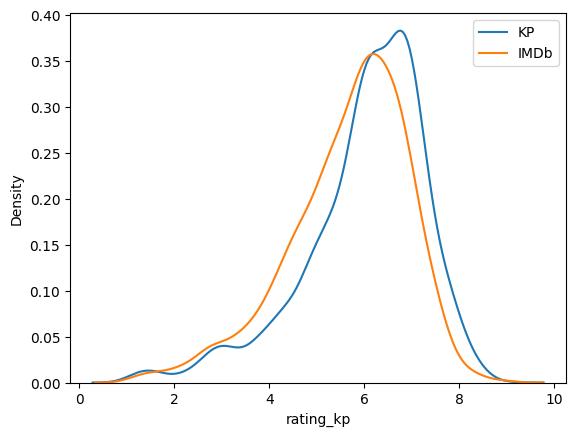

In [ ]:
# Сравнение оценок Кинопоиска и Imdb (Только для русских фильмов, оцененных на Imdb)

films_df_cleaned = films_df_cleaned[(films_df_cleaned['votes_imdb'] > 0) & (films_df_cleaned['votes_kp'] > 0)]
sns.kdeplot(films_df_cleaned['rating_kp'], label = 'KP')
sns.kdeplot(films_df_cleaned['rating_imdb'], label = 'IMDb')
plt.legend()

In [ ]:
films_df_exploded.to_csv('kp_final.csv')

## 3. Парсинг русских фильмов с главной страницы онлайн-кинотеатра Иви

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

def get_films_from_page(page_id):
    url = f"https://www.ivi.ru/movies/ru/page{page_id}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Ошибка доступа к странице {page_id} (код {response.status_code})")
        return []

    soup = BeautifulSoup(response.text, 'lxml')
    films = soup.findAll('li', class_='gallery__item gallery__item_virtual')

    if not films:
        return []  # Страница пуста, заканчиваем

    data = []

    for film in films:
        try:
            link = 'https://www.ivi.ru/' + film.find('a').get('href')
            name = film.find('div', class_='nbl-slimPosterBlock__title').find('span').text
            genre = film.find('div', class_='nbl-poster__propertiesInfo').find('div').text
            marks = film.find('div', class_='nbl-poster__propertiesRow').text
            data.append({
                'ссылка': link,
                'название': name,
                'жанр': genre,
                'оценка': marks
            })
        except AttributeError:
            continue

    return data

def all_films_across_pages(max_pages=33):
    all_data = []

    for page_id in range(1, max_pages + 1):
        print(f"Обрабатывается страница {page_id}...")
        page_data = get_films_from_page(page_id)
        if not page_data:
            print("Больше страниц не найдено.")
            break
        all_data.extend(page_data)
        time.sleep(1.5)  # Пауза, чтобы не вызвать блокировку

    return all_data

all_data = all_films_across_pages()

structured_data= []
for item in all_data:
    try:
        year, country, genre_type = item['жанр'].split(',', maxsplit=2)
        structured_data.append({
            'link': item['ссылка'],
            'title': item['название'],
            'year': int(year.strip()),
            'country': country.strip(),
            'genre': genre_type.strip(),
            'rating': float(item['оценка'].replace(',', '.'))
        })
    except (IndexError, ValueError):
        continue

df_ivi = pd.DataFrame(structured_data)
df_ivi

Обрабатывается страница 1...
Обрабатывается страница 2...
Обрабатывается страница 3...
Обрабатывается страница 4...
Обрабатывается страница 5...
Обрабатывается страница 6...
Обрабатывается страница 7...
Обрабатывается страница 8...
Обрабатывается страница 9...
Обрабатывается страница 10...
Обрабатывается страница 11...
Обрабатывается страница 12...
Обрабатывается страница 13...
Обрабатывается страница 14...
Обрабатывается страница 15...
Обрабатывается страница 16...
Обрабатывается страница 17...
Обрабатывается страница 18...
Обрабатывается страница 19...
Обрабатывается страница 20...
Обрабатывается страница 21...
Обрабатывается страница 22...
Обрабатывается страница 23...
Обрабатывается страница 24...
Обрабатывается страница 25...
Обрабатывается страница 26...
Обрабатывается страница 27...
Обрабатывается страница 28...
Обрабатывается страница 29...
Обрабатывается страница 30...
Обрабатывается страница 31...
Обрабатывается страница 32...
Обрабатывается страница 33...


,link,title,year,country,genre,rating
0,https://www.ivi.ru//watch/po-lyubvi,По любви,2025,Россия,Комедии,7.7
1,https://www.ivi.ru//watch/domovenok-kuzya,Домовёнок Кузя,2024,Россия,Комедии,8.2
2,https://www.ivi.ru//watch/postuchis-v-moyu-tver,Постучись в мою Тверь,2025,Россия,Комедии,7.9
3,https://www.ivi.ru//watch/bratya-2024,Братья,2024,Россия,Комедии,6.7
4,https://www.ivi.ru//watch/157373,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7
...,...,...,...,...,...,...
947,https://www.ivi.ru//watch/467529,Умная Маша,2022,Россия,Комедии,7.3
948,https://www.ivi.ru//watch/433499,Артек. Большое путешествие,2022,Россия,Комедии,8.5
949,https://www.ivi.ru//watch/melodiya-na-dva-golosa,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4
950,https://www.ivi.ru//watch/t-34-televersiya,Т-34. Полная версия,2020,Россия,Военные,8.7


## 4. Соберем режиссеров парсингом отдельных страничек фильмов с Иви и дообогатим через API Кинопоиска

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

def get_director_from_page(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return None
        soup = BeautifulSoup(response.text, 'html.parser')
        persons = soup.find_all('div', class_='nbl-fixedSlimPosterBlock__textSection')
        for person in persons:
            role = person.find('div', class_='nbl-fixedSlimPosterBlock__extraItem')
            if role and 'режиссёр' in role.text.lower():
                first_name = person.find('div', class_='nbl-fixedSlimPosterBlock__title')
                last_name = person.find('div', class_='nbl-fixedSlimPosterBlock__secondTitle')
                if first_name and last_name:
                    return f"{first_name.text.strip()} {last_name.text.strip()}"
        return None
    except Exception:
        return None

directors = []
for link in df_ivi['link']:
    directors.append(get_director_from_page(link))
    time.sleep(1)

df_ivi['director'] = directors
df_ivi

,link,title,year,country,genre,rating,director
0,https://www.ivi.ru//watch/po-lyubvi,По любви,2025,Россия,Комедии,7.7,Борис Милованов
1,https://www.ivi.ru//watch/domovenok-kuzya,Домовёнок Кузя,2024,Россия,Комедии,8.2,Виктор Лакисов
2,https://www.ivi.ru//watch/postuchis-v-moyu-tver,Постучись в мою Тверь,2025,Россия,Комедии,7.9,Симон Багдасарян
3,https://www.ivi.ru//watch/bratya-2024,Братья,2024,Россия,Комедии,6.7,Марк Горобец
4,https://www.ivi.ru//watch/157373,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7,Вера Сторожева
...,...,...,...,...,...,...,...
947,https://www.ivi.ru//watch/467529,Умная Маша,2022,Россия,Комедии,7.3,Андрей Никифоров
948,https://www.ivi.ru//watch/433499,Артек. Большое путешествие,2022,Россия,Комедии,8.5,Карен Захаров
949,https://www.ivi.ru//watch/melodiya-na-dva-golosa,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4,Сергей Мезенцев
950,https://www.ivi.ru//watch/t-34-televersiya,Т-34. Полная версия,2020,Россия,Военные,8.7,Алексей Сидоров


In [ ]:
df_ivi.to_csv('df_ivi_films.csv')

Получили датасет с фильмами и режиссерами с Иви

In [ ]:
df_ivi = pd.read_csv('df_ivi_films.csv', index_col=0)
df_ivi

,link,title,year,country,genre,rating,director
0,https://www.ivi.ru//watch/po-lyubvi,По любви,2025,Россия,Комедии,7.7,Борис Милованов
1,https://www.ivi.ru//watch/domovenok-kuzya,Домовёнок Кузя,2024,Россия,Комедии,8.2,Виктор Лакисов
2,https://www.ivi.ru//watch/postuchis-v-moyu-tver,Постучись в мою Тверь,2025,Россия,Комедии,7.9,Симон Багдасарян
3,https://www.ivi.ru//watch/bratya-2024,Братья,2024,Россия,Комедии,6.7,Марк Горобец
4,https://www.ivi.ru//watch/157373,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7,Вера Сторожева
...,...,...,...,...,...,...,...
947,https://www.ivi.ru//watch/467529,Умная Маша,2022,Россия,Комедии,7.3,Андрей Никифоров
948,https://www.ivi.ru//watch/433499,Артек. Большое путешествие,2022,Россия,Комедии,8.5,Карен Захаров
949,https://www.ivi.ru//watch/melodiya-na-dva-golosa,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4,Сергей Мезенцев
950,https://www.ivi.ru//watch/t-34-televersiya,Т-34. Полная версия,2020,Россия,Военные,8.7,Алексей Сидоров


Для поиска через API Кинопоиска режиссеров фильмов с Иви по именам воспользуемся эндпоинтом /person/search

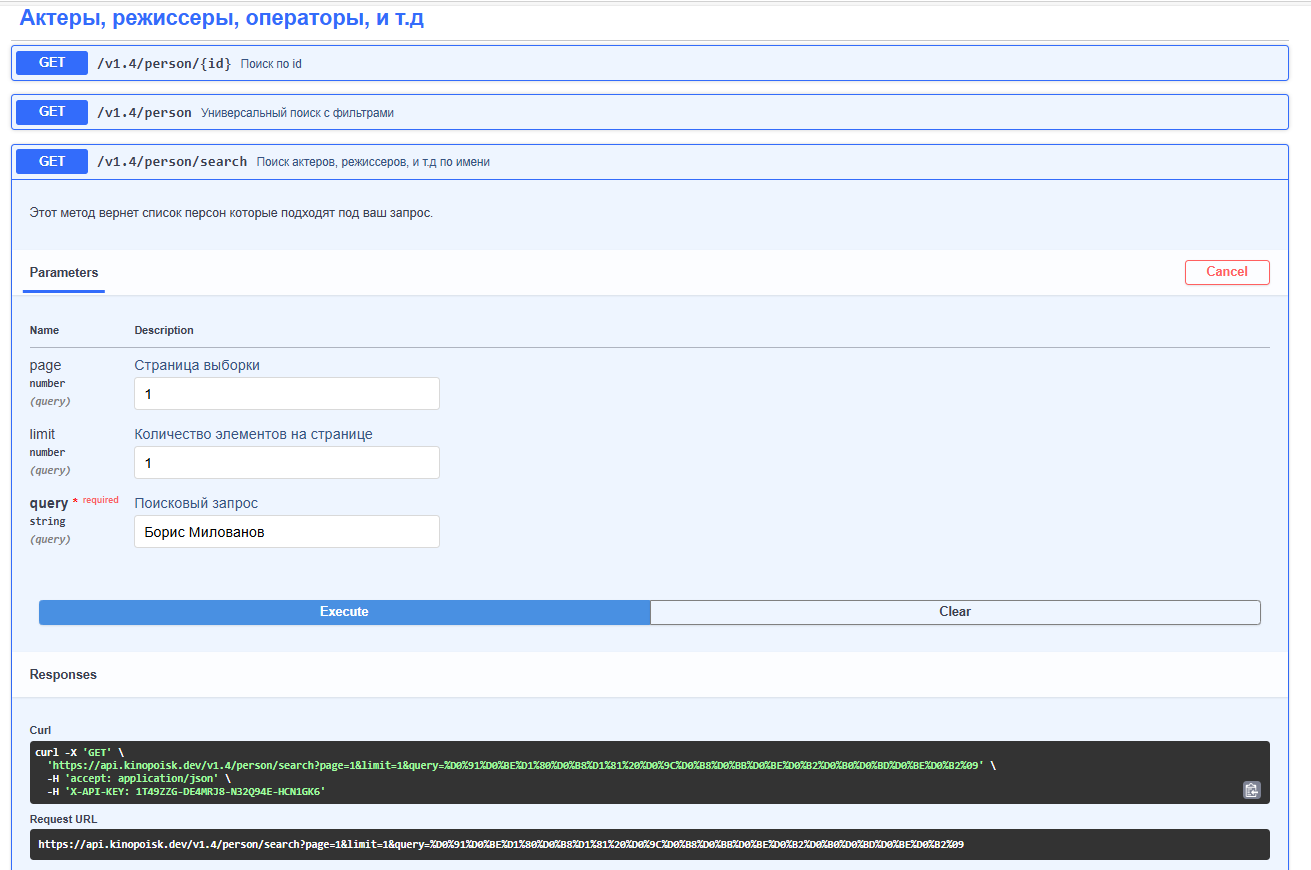

In [ ]:
def get_director_info(director_name):
    url = f'https://api.kinopoisk.dev/v1.4/person/search?page=1&limit=1&query={director_name}'
    response = requests.get(url, headers={'accept': 'application/json', 'X-API-KEY': key})

    if response.status_code == 200:
        return response.json()
    else:
        return None


# Словарь для хранения информации о режиссерах
bios_dict = {}

# Получаем уникальные director_id из DataFrame
unique_directors = df_ivi['director'].unique()

# Цикл для обработки каждого уникального director_id
for director_name in tqdm(unique_directors, desc="Fetching director info"):
    bio = get_director_info(director_name)['docs']

    if bio:
        bios_dict[director_name] = bio

# Присоединяем информацию о биографии по director_id в новый столбец
df_ivi['director_bio'] = df_ivi['director'].map(bios_dict)
df_ivi

Fetching director info: 100%|██████████| 258/258 [02:20<00:00,  1.83it/s]


,link,title,year,country,genre,rating,director,director_bio
0,https://www.ivi.ru//watch/po-lyubvi,По любви,2025,Россия,Комедии,7.7,Борис Милованов,"[{'id': 5388468, 'name': 'Борис Милованов', 'e..."
1,https://www.ivi.ru//watch/domovenok-kuzya,Домовёнок Кузя,2024,Россия,Комедии,8.2,Виктор Лакисов,"[{'id': 1204032, 'name': 'Виктор Лакисов', 'en..."
2,https://www.ivi.ru//watch/postuchis-v-moyu-tver,Постучись в мою Тверь,2025,Россия,Комедии,7.9,Симон Багдасарян,"[{'id': 6628869, 'name': 'Симон Багдасарян', '..."
3,https://www.ivi.ru//watch/bratya-2024,Братья,2024,Россия,Комедии,6.7,Марк Горобец,"[{'id': 1818628, 'name': 'Марк Горобец', 'enNa..."
4,https://www.ivi.ru//watch/157373,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7,Вера Сторожева,"[{'id': 231283, 'name': 'Вера Сторожева', 'enN..."
...,...,...,...,...,...,...,...,...
947,https://www.ivi.ru//watch/467529,Умная Маша,2022,Россия,Комедии,7.3,Андрей Никифоров,"[{'id': 4545235, 'name': 'Андрей Никифоров', '..."
948,https://www.ivi.ru//watch/433499,Артек. Большое путешествие,2022,Россия,Комедии,8.5,Карен Захаров,"[{'id': 1557058, 'name': 'Карен Захаров', 'enN..."
949,https://www.ivi.ru//watch/melodiya-na-dva-golosa,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4,Сергей Мезенцев,"[{'id': 2764996, 'name': 'Сергей Мезенцев', 'e..."
950,https://www.ivi.ru//watch/t-34-televersiya,Т-34. Полная версия,2020,Россия,Военные,8.7,Алексей Сидоров,"[{'id': 2547862, 'name': 'Алексей Сидоров', 'e..."


In [ ]:
df_ivi['director_bio'] = df_ivi['director_bio'].apply(lambda x: x[0])

In [ ]:
df_ivi

,link,title,year,country,genre,rating,director,director_bio
0,https://www.ivi.ru//watch/po-lyubvi,По любви,2025,Россия,Комедии,7.7,Борис Милованов,"{'id': 5388468, 'name': 'Борис Милованов', 'en..."
1,https://www.ivi.ru//watch/domovenok-kuzya,Домовёнок Кузя,2024,Россия,Комедии,8.2,Виктор Лакисов,"{'id': 1204032, 'name': 'Виктор Лакисов', 'enN..."
2,https://www.ivi.ru//watch/postuchis-v-moyu-tver,Постучись в мою Тверь,2025,Россия,Комедии,7.9,Симон Багдасарян,"{'id': 6628869, 'name': 'Симон Багдасарян', 'e..."
3,https://www.ivi.ru//watch/bratya-2024,Братья,2024,Россия,Комедии,6.7,Марк Горобец,"{'id': 1818628, 'name': 'Марк Горобец', 'enNam..."
4,https://www.ivi.ru//watch/157373,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7,Вера Сторожева,"{'id': 231283, 'name': 'Вера Сторожева', 'enNa..."
...,...,...,...,...,...,...,...,...
947,https://www.ivi.ru//watch/467529,Умная Маша,2022,Россия,Комедии,7.3,Андрей Никифоров,"{'id': 4545235, 'name': 'Андрей Никифоров', 'e..."
948,https://www.ivi.ru//watch/433499,Артек. Большое путешествие,2022,Россия,Комедии,8.5,Карен Захаров,"{'id': 1557058, 'name': 'Карен Захаров', 'enNa..."
949,https://www.ivi.ru//watch/melodiya-na-dva-golosa,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4,Сергей Мезенцев,"{'id': 2764996, 'name': 'Сергей Мезенцев', 'en..."
950,https://www.ivi.ru//watch/t-34-televersiya,Т-34. Полная версия,2020,Россия,Военные,8.7,Алексей Сидоров,"{'id': 2547862, 'name': 'Алексей Сидоров', 'en..."


In [ ]:
# Преобразуем строки в словари и извлекаем данные
df_ivi['birthday'] = df_ivi['director_bio'].apply(
    lambda bio: pd.to_datetime(bio.get('birthday', None), errors='coerce')
).dt.date

df_ivi['death'] = df_ivi['director_bio'].apply(
    lambda bio: pd.to_datetime(bio.get('death', None), errors='coerce')
).dt.date

df_ivi

,link,title,year,country,genre,rating,director,director_bio,birthday,death
0,https://www.ivi.ru//watch/po-lyubvi,По любви,2025,Россия,Комедии,7.7,Борис Милованов,"{'id': 5388468, 'name': 'Борис Милованов', 'en...",1987-05-05,NaT
1,https://www.ivi.ru//watch/domovenok-kuzya,Домовёнок Кузя,2024,Россия,Комедии,8.2,Виктор Лакисов,"{'id': 1204032, 'name': 'Виктор Лакисов', 'enN...",1976-07-23,NaT
2,https://www.ivi.ru//watch/postuchis-v-moyu-tver,Постучись в мою Тверь,2025,Россия,Комедии,7.9,Симон Багдасарян,"{'id': 6628869, 'name': 'Симон Багдасарян', 'e...",1990-08-24,NaT
3,https://www.ivi.ru//watch/bratya-2024,Братья,2024,Россия,Комедии,6.7,Марк Горобец,"{'id': 1818628, 'name': 'Марк Горобец', 'enNam...",1975-05-30,NaT
4,https://www.ivi.ru//watch/157373,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7,Вера Сторожева,"{'id': 231283, 'name': 'Вера Сторожева', 'enNa...",1958-09-07,NaT
...,...,...,...,...,...,...,...,...,...,...
947,https://www.ivi.ru//watch/467529,Умная Маша,2022,Россия,Комедии,7.3,Андрей Никифоров,"{'id': 4545235, 'name': 'Андрей Никифоров', 'e...",1986-02-28,NaT
948,https://www.ivi.ru//watch/433499,Артек. Большое путешествие,2022,Россия,Комедии,8.5,Карен Захаров,"{'id': 1557058, 'name': 'Карен Захаров', 'enNa...",1976-06-21,NaT
949,https://www.ivi.ru//watch/melodiya-na-dva-golosa,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4,Сергей Мезенцев,"{'id': 2764996, 'name': 'Сергей Мезенцев', 'en...",1982-11-14,NaT
950,https://www.ivi.ru//watch/t-34-televersiya,Т-34. Полная версия,2020,Россия,Военные,8.7,Алексей Сидоров,"{'id': 2547862, 'name': 'Алексей Сидоров', 'en...",NaT,NaT


In [ ]:
df_ivi.to_csv('ivi_final.csv')

## 5. EDA

На предыдущих этапах были получены датасеты русских фильмов с режиссерами с Кинопоиска и Иви.

In [ ]:
kp_final = pd.read_csv('kp_final.csv', index_col=0)
kp_final.drop(['id', 'director_bio', 'director_id'], axis=1, inplace=True)
kp_final.dropna(subset='birthday', inplace=True)
kp_final.reset_index(drop=True, inplace=True)
kp_final

,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,countries,main_genre,birthday,death
0,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,Россия,комедия,1982-03-07,NaN
1,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,Россия,ужасы,1989-02-07,NaN
2,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,Россия,комедия,1988-10-19,NaN
3,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,Россия,триллер,1981-01-01,NaN
4,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,Россия,драма,1934-04-17,1999-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...
5288,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Хармони Корин,"Польша, Россия, США",драма,1973-01-04,NaN
5289,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Ян Квечински,"Польша, Россия, США",драма,1985-12-01,NaN
5290,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Алексей Федорченко,"Польша, Россия, США",драма,1966-09-29,NaN
5291,Палата №6,6.638,6.3,13019,844,2009,драма,Александр Горновский,Россия,драма,1973-02-27,NaN


In [ ]:
kp_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5293 entries, 0 to 5292
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         5293 non-null   object 
 1   rating_kp    5293 non-null   float64
 2   rating_imdb  5293 non-null   float64
 3   votes_kp     5293 non-null   int64  
 4   votes_imdb   5293 non-null   int64  
 5   year         5293 non-null   int64  
 6   genre        5293 non-null   object 
 7   director     5293 non-null   object 
 8   countries    5293 non-null   object 
 9   main_genre   5293 non-null   object 
 10  birthday     5293 non-null   object 
 11  death        666 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 496.3+ KB


In [ ]:
ivi_final = pd.read_csv('ivi_final.csv', index_col=0)
ivi_final.drop(['link', 'director_bio'], axis=1, inplace=True)
ivi_final.dropna(subset='birthday', inplace=True)
ivi_final.reset_index(drop=True, inplace=True)
ivi_final

,title,year,country,genre,rating,director,birthday,death
0,По любви,2025,Россия,Комедии,7.7,Борис Милованов,1987-05-05,NaN
1,Домовёнок Кузя,2024,Россия,Комедии,8.2,Виктор Лакисов,1976-07-23,NaN
2,Постучись в мою Тверь,2025,Россия,Комедии,7.9,Симон Багдасарян,1990-08-24,NaN
3,Братья,2024,Россия,Комедии,6.7,Марк Горобец,1975-05-30,NaN
4,Сдается дом со всеми неудобствами,2016,Россия,Комедии,6.7,Вера Сторожева,1958-09-07,NaN
...,...,...,...,...,...,...,...,...
714,Ледокол,2016,Россия,Катастрофы,8.0,Николай Хомерики,1975-04-17,NaN
715,Умная Маша,2022,Россия,Комедии,7.3,Андрей Никифоров,1986-02-28,NaN
716,Артек. Большое путешествие,2022,Россия,Комедии,8.5,Карен Захаров,1976-06-21,NaN
717,Мелодия на два голоса,2015,Россия,Мелодрамы,7.4,Сергей Мезенцев,1982-11-14,NaN


In [ ]:
ivi_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     719 non-null    object 
 1   year      719 non-null    int64  
 2   country   719 non-null    object 
 3   genre     719 non-null    object 
 4   rating    719 non-null    float64
 5   director  719 non-null    object 
 6   birthday  719 non-null    object 
 7   death     38 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 45.1+ KB


In [ ]:
genre_mapping = {
    'комедия': 'Комедии',
    'ужасы': 'Ужасы',
    'триллер': 'Триллеры',
    'драма': 'Драмы',
    'мелодрама': 'Мелодрамы',
    'приключения': 'Приключения',
    'детский': 'Для детей',
    'документальный': 'Документальные',
    'семейный': 'Для детей',
    'биография': 'Документальные',
    'боевик': 'Боевики',
    'фантастика': 'Фантастика',
    'спорт': 'Спорт',
    'детектив': 'Детективы',
    'фэнтези': 'Фэнтези',
    'криминал': 'Криминал',
    'история': 'Исторические',
    'военный': 'Военные',
    'мюзикл': 'Музыкальные',
    'музыка': 'Музыкальные',
    'ток-шоу': 'Ток-шоу',
    'Фильмы-спектакли': 'Фильмы-спектакли',
    'для взрослых': 'Для взрослых',
    'Артхаус': 'Артхаус',
    'церемония': 'Церемония',
    'концерт': 'Музыкальные'
}

# Обновим жанры в датасете Кинопоиска по маппингу
kp_final['main_genre'] = kp_final['main_genre'].map(genre_mapping)
kp_final

,name,rating_kp,rating_imdb,votes_kp,votes_imdb,year,genre,director,countries,main_genre,birthday,death
0,Грецкий орешек,6.313,0.0,33123,0,2018,"комедия, приключения",Стас Иванов,Россия,Комедии,1982-03-07,NaN
1,Пиковая дама: Зазеркалье,5.510,5.0,29683,786,2018,ужасы,Александр Домогаров мл.,Россия,Ужасы,1989-02-07,NaN
2,Девушка с косой,6.267,5.4,27631,95,2017,комедия,Ольга Гнедич,Россия,Комедии,1988-10-19,NaN
3,Тибра,6.111,0.0,31425,0,2022,триллер,Анна Гороян,Россия,Триллеры,1981-01-01,NaN
4,Барышня-крестьянка,8.073,6.8,36357,368,1995,"драма, мелодрама",Алексей Сахаров,Россия,Драмы,1934-04-17,1999-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...
5288,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Хармони Корин,"Польша, Россия, США",Драмы,1973-01-04,NaN
5289,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Ян Квечински,"Польша, Россия, США",Драмы,1985-12-01,NaN
5290,Четвертое измерение,5.980,6.0,406,556,2012,"драма, комедия, приключения",Алексей Федорченко,"Польша, Россия, США",Драмы,1966-09-29,NaN
5291,Палата №6,6.638,6.3,13019,844,2009,драма,Александр Горновский,Россия,Драмы,1973-02-27,NaN


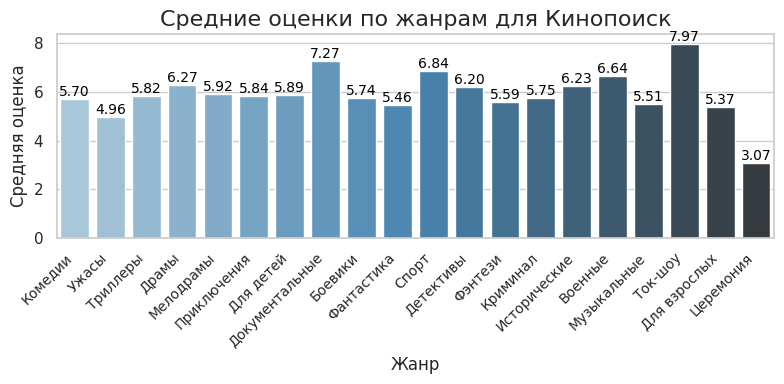

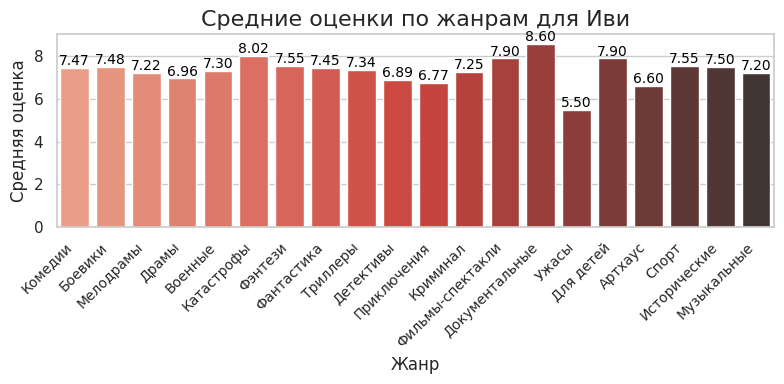

In [ ]:
# Построим график для Кинопоиск с подписями значений
plt.figure(figsize=(8, 4))
ax1 = sns.barplot(x='main_genre', y='rating_kp', data=kp_final, palette="Blues_d", ci=None)
plt.title('Средние оценки по жанрам для Кинопоиск', fontsize=16)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Добавляем подписи значений
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Построим график для Иви с подписями значений
plt.figure(figsize=(8, 4))
ax2 = sns.barplot(x='genre', y='rating', data=ivi_final, palette="Reds_d", ci=None)
plt.title('Средние оценки по жанрам для Иви', fontsize=16)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Добавляем подписи значений
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# Приводим структуру столбцов в обоих датафреймах к одинаковому виду
kp_final_concat = kp_final[['name', 'director', 'rating_kp', 'main_genre', 'birthday', 'death']]
ivi_final_concat = ivi_final[['title', 'director', 'rating', 'genre', 'birthday', 'death']].rename(columns={'title': 'name', 'genre': 'main_genre'})

# Переименовываем столбцы в iv_final для единообразия
ivi_final_concat = ivi_final_concat.rename(columns={'rating': 'rating_ivi'})

# Конкатенируем два датафрейма
merged_df = pd.concat([kp_final_concat, ivi_final_concat], ignore_index=True)
merged_df.drop_duplicates(subset=['name'], inplace=True)
merged_df.reset_index(inplace=True)
merged_df = merged_df[['name', 'director', 'rating_kp', 'rating_ivi', 'main_genre', 'birthday', 'death']]
merged_df

,name,director,rating_kp,rating_ivi,main_genre,birthday,death
0,Грецкий орешек,Стас Иванов,6.313,NaN,Комедии,1982-03-07,NaN
1,Пиковая дама: Зазеркалье,Александр Домогаров мл.,5.510,NaN,Ужасы,1989-02-07,NaN
2,Девушка с косой,Ольга Гнедич,6.267,NaN,Комедии,1988-10-19,NaN
3,Тибра,Анна Гороян,6.111,NaN,Триллеры,1981-01-01,NaN
4,Барышня-крестьянка,Алексей Сахаров,8.073,NaN,Драмы,1934-04-17,1999-01-21
...,...,...,...,...,...,...,...
4705,Останьтесь навсегда,Сергей Гиргель,NaN,6.5,Мелодрамы,1976-12-19,NaN
4706,"Здравствуйте, Вам!",Владимир Крайнев,NaN,7.1,Мелодрамы,1948-03-05,NaN
4707,Игра в прятки,Мария Можар,NaN,7.5,Мелодрамы,1978-12-16,NaN
4708,Белый паровоз,Павел Снисаренко,NaN,8.0,Комедии,1972-07-05,NaN


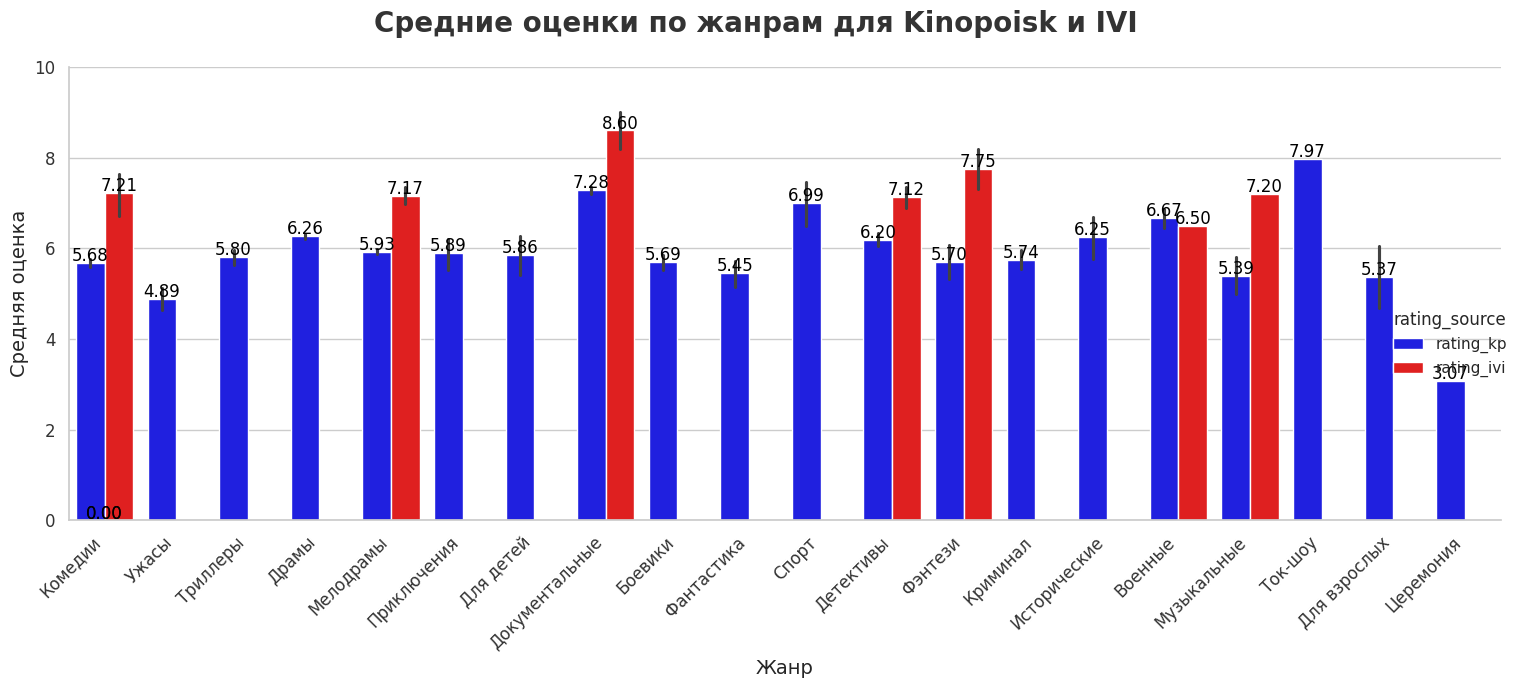

In [ ]:
# Рассчитаем средние рейтинги по жанрам для обоих кинотеатров
genre_ratings = merged_df.melt(id_vars=['main_genre'], value_vars=['rating_kp', 'rating_ivi'],
                               var_name='rating_source', value_name='rating')

# Используем sns.catplot для создания графика с двумя категориями рядом
sns.set(style="whitegrid")
g = sns.catplot(x='main_genre', y='rating', hue='rating_source', data=genre_ratings, kind='bar', height=7, aspect=2,
                palette={'rating_kp': 'blue', 'rating_ivi': 'red'})

# Добавляем заголовок и подписи
g.fig.suptitle('Средние оценки по жанрам для Kinopoisk и IVI', fontsize=20, fontweight='bold', color='#333')
g.set_axis_labels('Жанр', 'Средняя оценка', fontsize=14)
g.set_xticklabels(rotation=45, ha='right', fontsize=12, color='#333')
g.set_yticklabels(fontsize=12, color='#333')

# Добавляем подписи значений для каждого столбца
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                    fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Покажем график
plt.tight_layout()
plt.show()


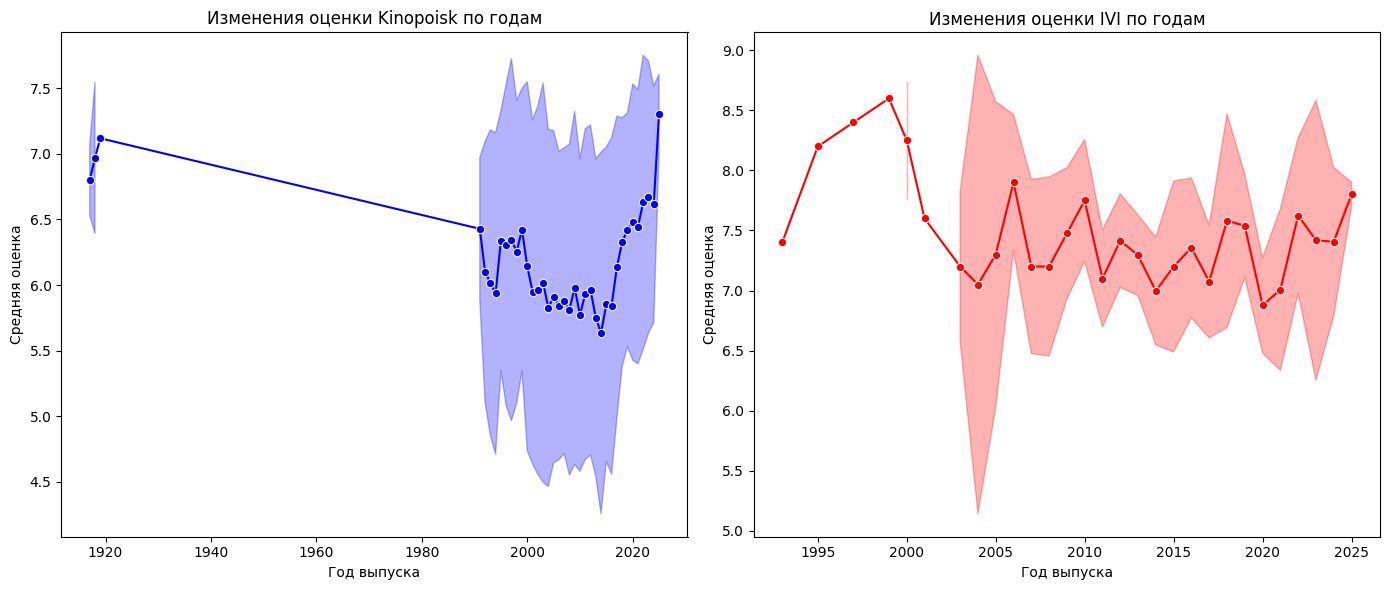

In [ ]:
# Построим изменения оценок по годам выпуска для каждого датасета
plt.figure(figsize=(14, 6))

# График изменения оценок по годам для Кинопоиск с полосами погрешности
plt.subplot(1, 2, 1)
yearly_kp = kp_final.groupby('year')['rating_kp'].agg(['mean', 'std']).reset_index()
sns.lineplot(data=yearly_kp, x='year', y='mean', marker='o', color='blue')
plt.fill_between(yearly_kp['year'], yearly_kp['mean'] - yearly_kp['std'], yearly_kp['mean'] + yearly_kp['std'], color='blue', alpha=0.3)
plt.title('Изменения оценки Kinopoisk по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя оценка')

# График изменения оценок по годам для Иви с полосами погрешности
plt.subplot(1, 2, 2)
yearly_ivi = ivi_final.groupby('year')['rating'].agg(['mean', 'std']).reset_index()
sns.lineplot(data=yearly_ivi, x='year', y='mean', marker='o', color='red')
plt.fill_between(yearly_ivi['year'], yearly_ivi['mean'] - yearly_ivi['std'], yearly_ivi['mean'] + yearly_ivi['std'], color='red', alpha=0.3)
plt.title('Изменения оценки IVI по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя оценка')

plt.tight_layout()
plt.show()


Корреляция между рейтингами Кинопоиска и IVI: 0.32


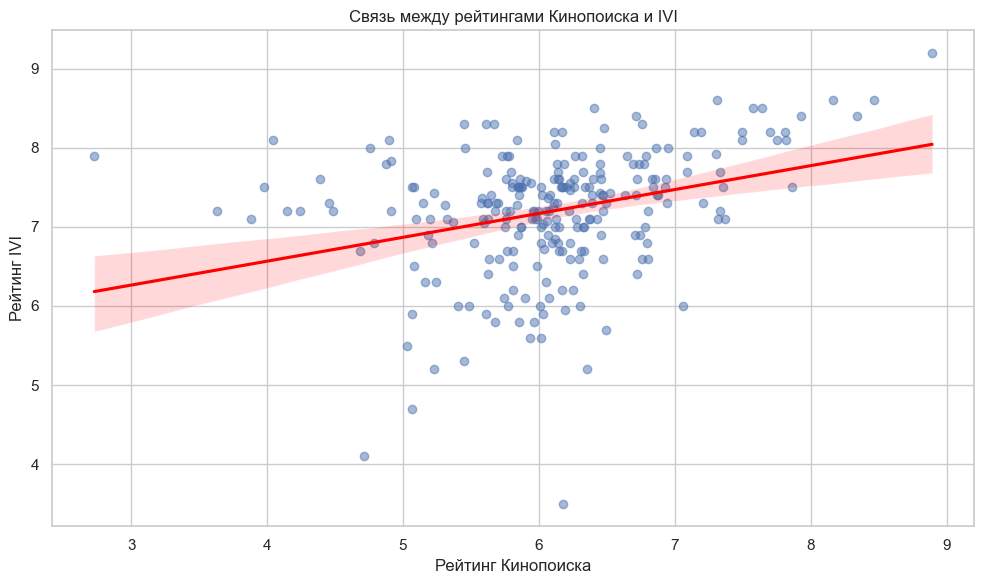

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_kp = pd.read_csv("films_df_exploded.csv")
df_ivi = pd.read_csv("ivi_final.csv")

# Словарь сопоставлений жанров
genre_map = {
    "Комедии": "комедия",
    "Боевики": "боевик",
    "Мелодрамы": "мелодрама",
    "Драмы": "драма",
    "Военные": "военный",
    "Фэнтези": "фэнтези",
    "Документальные": "документальный",
    "Фантастика": "фантастика",
    "Триллеры": "триллер",
    "Детективы": "детектив",
    "Спорт": "спорт",
    "Приключения": "приключения",
    "Криминал": "криминал",
    "Ужасы": "ужасы",
    "Для детей": "детский",
    "Исторические": "история",
    "Музыкальные": "музыка"
}

# Обработка данных IVI
df_ivi_clean = df_ivi.rename(columns={"rating": "rating_ivi", "genre": "main_genre"})
df_ivi_clean["main_genre_mapped"] = df_ivi_clean["main_genre"].map(genre_map)
df_ivi_grouped = df_ivi_clean.dropna(subset=["main_genre_mapped"])
df_ivi_grouped = (
    df_ivi_grouped.groupby(["director", "main_genre_mapped"])["rating_ivi"]
    .mean()
    .reset_index()
    .rename(columns={"main_genre_mapped": "main_genre"})
)

# Обработка данных Кинопоиска
df_kp_filtered = df_kp[["director", "main_genre", "rating_kp"]].dropna()
df_kp_filtered = df_kp_filtered[df_kp_filtered["rating_kp"] > 0]
df_kp_grouped = (
    df_kp_filtered.groupby(["director", "main_genre"])["rating_kp"]
    .mean()
    .reset_index()
)

merged_df = pd.merge(df_kp_grouped, df_ivi_grouped, on=["director", "main_genre"])

correlation = merged_df["rating_kp"].corr(merged_df["rating_ivi"])
print(f"Корреляция между рейтингами Кинопоиска и IVI: {correlation:.2f}")

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.regplot(
    data=merged_df,
    x="rating_kp",
    y="rating_ivi",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)

plt.title("Связь между рейтингами Кинопоиска и IVI")
plt.xlabel("Рейтинг Кинопоиска")
plt.ylabel("Рейтинг IVI")
plt.tight_layout()
plt.show()



In [31]:
import pandas as pd
import plotly.express as px

# Загрузи исходный датафрейм, если его ещё нет
df = pd.read_csv("films_df_exploded.csv")

# Функция для извлечения года рождения
import ast
from datetime import datetime

def extract_birth_year(bio):
    try:
        bio_dict = ast.literal_eval(bio)
        birthday = bio_dict.get("birthday")
        if birthday:
            return datetime.fromisoformat(birthday.replace("Z", "")).year
    except:
        return None

# Добавим столбец с годом рождения
df["birth_year"] = df["director_bio"].apply(extract_birth_year)

# Фильтруем необходимые столбцы
df_filtered = df[["director", "main_genre", "rating_kp", "birth_year"]].dropna()
df_filtered = df_filtered[df_filtered["rating_kp"] > 0]

# Находим самый частый жанр у каждого режиссёра
genre_counts = (
    df_filtered.groupby(["director", "main_genre"])
    .size()
    .reset_index(name="film_count")
)
top_genres = genre_counts.sort_values("film_count", ascending=False).drop_duplicates("director")

# Средний рейтинг Кинопоиска по самому популярному жанру
avg_ratings = (
    df_filtered.groupby(["director", "main_genre"])["rating_kp"]
    .mean()
    .reset_index(name="avg_rating_kp")
)

# Объединение
merged = pd.merge(top_genres, avg_ratings, on=["director", "main_genre"])
birth_years = df_filtered[["director", "birth_year"]].drop_duplicates()
final_df = pd.merge(merged, birth_years, on="director")

# Интерактивный график Plotly
fig = px.scatter(
    final_df,
    x="birth_year",
    y="avg_rating_kp",
    color="main_genre",
    size="film_count",
    hover_name="director",
    hover_data={
        "main_genre": True,
        "birth_year": True,
        "avg_rating_kp": True,
        "film_count": True
    },
    labels={
        "birth_year": "Год рождения",
        "avg_rating_kp": "Средний рейтинг Кинопоиска",
        "main_genre": "Жанр",
        "film_count": "Количество фильмов"
    },
    title="Интерактивный график: Рейтинг режиссёра по жанру и году рождения (Кинопоиск)"
)

fig.update_layout(legend_title_text='Жанр')



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([['мелодрама', 19],
                                   ['мелодрама', 11],
                                   ['мелодрама', 10],
                                   ...,
                                   ['мелодрама', 1],
                                   ['мелодрама', 1],
                                   ['мелодрама', 1]], shape=(253, 2), dtype=object),
              'hovertemplate': ('<b>%{hovertext}</b><br><br>Жан' ... '{customdata[1]}<extra></extra>'),
              'hovertext': array(['Андрей Селиванов', 'Александр Кананович', 'Дмитрий Сорокин', ...,
                                  'Юлия Мазурова', 'Юрий Хмельницкий', 'Автандил Квирикашвили'],
                                 shape=(253,), dtype=object),
              'legendgroup': 'мелодрама',
              'marker': {'color': '#636efa',
                         'size': {'bdata': ('EwsKCgkICAcHBwcHBwcGBgUFBQUFBQ' ... 'EBAQEBAQEBAQEBAQEBAQEBAQEBAQ=='),
                                  'dtype': 'i1'},
                         'sizemode': 'area',
                         'sizeref': 0.0475,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': 'мелодрама',
              'showlegend': True,
              'type': 'scattergl',
              'x': {'bdata': ('AAAAAAC4nkAAAAAAAOSeQAAAAAAAyJ' ... 'AAANSeQAAAAAAAGJ9AAAAAAABonkA='),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('CRhXaAg+GEDs1V34dp8XQP5l9+RhIR' ... 'lBYOUYQJzEILByaCBAdZMYBFaOE0A='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'customdata': array([['комедия', 18],
                                   ['комедия', 14],
                                   ['комедия', 12],
                                   ...,
                                   ['комедия', 1],
                                   ['комедия', 1],
                                   ['комедия', 1]], shape=(385, 2), dtype=object),
              'hovertemplate': ('<b>%{hovertext}</b><br><br>Жан' ... '{customdata[1]}<extra></extra>'),
              'hovertext': array(['Стас Шеминов', 'Марюс Вайсберг', 'Анатолий Эйрамджан', ...,
                                  'Яна Гладких', 'Яна Романенко', 'Авет Оганесян'],
                                 shape=(385,), dtype=object),
              'legendgroup': 'комедия',
              'marker': {'color': '#EF553B',
                         'size': {'bdata': ('Eg4MCwsKCAcHBwcHBwcGBgYGBQUFBQ' ... 'EBAQEBAQEBAQEBAQEBAQEBAQEBAQ=='),
                                  'dtype': 'i1'},
                         'sizemode': 'area',
                         'sizeref': 0.0475,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': 'комедия',
              'showlegend': True,
              'type': 'scattergl',
              'x': {'bdata': ('AAAAAAAIn0AAAAAAAMyeQAAAAAAARJ' ... 'AAAByfQAAAAAAA9J5AAAAAAAAgn0A='),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('qewwdbndIEAOLbKd76cTQIIH80T9Gx' ... 'x0k5gVQGDl0CLb+RhAhxbZzvdTGkA='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'customdata': array([['документальный', 14],
                                   ['документальный', 14],
                                   ['документальный', 11],
                                   ...,
                                   ['документальный', 1],
                                   ['документальный', 1],
                                   ['документальный', 1]], shape=(279, 2), dtype=object),
              'hovertemplate': ('<b>%{hovertext}</b><br><br>Жан' ... '{customdata[1]}<extra></extra>'),
              'hovertext': array(['Сергей Нурмамед', 'Овез Нарлиев', 'Виталий Манский', ...,
                                  'Юрий Власов', 'Юрий Дегтярев', 'Uwe Anders'],
                                 shape=(279,), dtype=object),
              'legendgroup': 'док